# Car price prediction

We need to predict the market value of the car. Available: technical characteristics, configurations and prices of vehicles. We need to build a model to determine the cost.

## Loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import time
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

## 1. Load the dataset

Let's load the dataset and look throuhg the first lines.

In [79]:
data = pd.read_csv('/datasets/autos.csv')
data_row = pd.read_csv('/datasets/autos.csv')
pd.set_option('display.max_columns', None)
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


The column `NumberOfPictures` looks to be useless, let's check how many values does it contain

In [3]:
data['NumberOfPictures'].value_counts()

0    354369
Name: NumberOfPictures, dtype: int64

In [4]:
#drop this column
data = data.drop(['NumberOfPictures'], axis=1)

**Features**

`DateCrawled` — date when the data has been downloaded

`VehicleType` — type of car body

`RegistrationYear` — year of vehicle registration

`Gearbox` — type of gearbox

`Power` — power (hp)

`Model` — car model

`Kilometer` — mileage (km)

`RegistrationMonth` — month of car registration

`FuelType` — type of fuel

`Brand` — car brand

`NotRepaired` — was the car under repair or not

`DateCreated` — date of creation of the questionnaire

`PostalCode` — postal code of the owner of the profile (user)

`LastSeen` — date of last user activity

**Target feature**

`Price` - price (euro)

### Check the shape of dataset and types of data.

In [5]:
print('Dataset has {} rows and {} columns'.format(data.shape[0],data.shape[1]))

Dataset has 354369 rows and 15 columns


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  PostalCode         354369 non-null  int64 
 14  LastSeen           354369 non-null  object
dtypes: int64(6), object(9)
memory usage: 40.6+ MB


Let's change the type of date columns to datetime.

In [7]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled']) 
data['DateCreated'] = pd.to_datetime(data['DateCreated']) 
data['LastSeen'] = pd.to_datetime(data['LastSeen']) 

### Data processing.

#### Missing data

Make a function to detect the % of missing values in dataset

In [8]:
def missing(df):
    for i in data.columns:
        if data[i].isna().sum() / len(data) > 0:
            print('% of missing values in {} is {:,.2f}.\n Number of missing values:'.
                  format(i, (data[i].isna().sum() / len(data))*100), data[i].isna().sum())

In [9]:
missing(data)

% of missing values in VehicleType is 10.58.
 Number of missing values: 37490
% of missing values in Gearbox is 5.60.
 Number of missing values: 19833
% of missing values in Model is 5.56.
 Number of missing values: 19705
% of missing values in FuelType is 9.28.
 Number of missing values: 32895
% of missing values in Repaired is 20.08.
 Number of missing values: 71154


Let's count the number of rows where data in columns `VehicleType`, `Gearbox`, `Model` and `FuelType` is missing simultaneously.

In [10]:
print('Missing value is {}%'.format(round((len(data[(data['VehicleType'].isna()) &
                                                   (data['Gearbox'].isna()) &
                                                   (data['Model'].isna()) &
                                                   (data['FuelType'].isna())]) / (len(data)) * 100), 2)))

Missing value is 0.68%


The percentage is insignificant, we can get rid of these rows.

In [11]:
data.dropna(axis=0, how='all', subset=['VehicleType', 'Gearbox', 'Model', 'FuelType'], inplace=True)

Let's work with missing data at each column.

In [12]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
count,351977.000000,351977.000000,351977.000000,351977.000000,351977.000000,351977.000000
mean,4438.998889,2003.875375,110.743012,128447.284908,5.748236,50537.367811
std,4516.837414,70.488638,190.225922,37548.322925,3.711517,25779.045240
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1100.000000,1999.000000,69.000000,125000.000000,3.000000,30167.000000
50%,2750.000000,2003.000000,105.000000,150000.000000,6.000000,49429.000000
75%,6450.000000,2008.000000,143.000000,150000.000000,9.000000,71101.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000


**VehicleType**

Let's check lines with missing type of vehicle.

In [13]:
data[data['VehicleType'].isna()].sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
289562,2016-03-12 16:49:55,1450,NaN,2005,NaN,0,golf,150000,0,NaN,volkswagen,NaN,2016-03-12,67551,2016-03-12 16:49:55
51274,2016-03-20 11:38:54,2699,NaN,2017,manual,0,golf,150000,3,NaN,volkswagen,no,2016-03-20,73035,2016-04-06 08:46:37
334376,2016-03-27 14:49:54,5000,NaN,2006,NaN,0,fabia,90000,0,NaN,skoda,NaN,2016-03-27,69509,2016-04-07 11:45:05
44428,2016-03-20 22:56:45,750,NaN,2017,manual,0,ka,125000,7,petrol,ford,NaN,2016-03-20,25361,2016-04-07 11:44:24
286627,2016-03-05 15:28:30,1500,NaN,1970,auto,90,NaN,100000,3,NaN,opel,NaN,2016-03-05,65207,2016-03-09 03:44:53


There is no any obvious relation between other features and missing data, we can group the dataset by `Model` and to fill in the first value in each group.

In [14]:
data.loc[data['VehicleType'].isna(), 'VehicleType'] = data.loc[data['VehicleType'].isna(), 'Model'].map(data.groupby(['Model'])['VehicleType'].first())

In [15]:
print('Missing {:,.2f} %'.format((data['VehicleType'].isna().sum()) / len(data)))

Missing 0.01 %


In [16]:
#we can drop the rest of missing values
data.dropna(subset=['VehicleType'], inplace=True)

##### Gearbox

In [17]:
data[data['Gearbox'].isna()].sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
166176,2016-03-29 17:06:20,3100,wagon,2008,NaN,0,touran,150000,7,gasoline,volkswagen,no,2016-03-29,57518,2016-03-29 17:06:20
252375,2016-03-07 14:38:53,5650,sedan,2003,NaN,163,a6,150000,6,gasoline,audi,NaN,2016-03-07,59063,2016-03-20 18:24:22
231730,2016-03-29 20:51:41,3800,sedan,2001,NaN,0,5er,150000,1,gasoline,bmw,NaN,2016-03-29,24568,2016-03-29 20:51:41
306766,2016-03-10 20:50:44,5555,bus,2007,NaN,0,zafira,150000,9,petrol,opel,no,2016-03-10,64743,2016-04-06 09:16:12
315149,2016-03-08 17:55:44,250,small,2000,NaN,0,twingo,150000,0,NaN,renault,NaN,2016-03-08,87773,2016-04-07 08:46:37


Let's group dataset by Model and fill in the first value in each group. Ignore the fact that the same model can have either manual or auto. Taking into acount the quantity of missing data, it shouldn't affect the analysis badly.

In [18]:
data.loc[data['Gearbox'].isna(), 'Gearbox'] = data.loc[data['Gearbox'].isna(), 'Model'].map(data.groupby(['Model'])['Gearbox'].first())

In [19]:
print('Missing {:,.2f} %'.format((data['Gearbox'].isna().sum()) / len(data)))

Missing 0.00 %


In [20]:
#we can drop the rest of missing values
data.dropna(subset=['Gearbox'], inplace=True)

##### Model        

In [21]:
data[data['Model'].isna()].sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
81724,2016-04-02 16:51:02,4000,small,2009,manual,65,NaN,150000,8,petrol,fiat,no,2016-04-02,12629,2016-04-06 16:15:48
221474,2016-03-22 10:50:40,200,small,1999,manual,0,NaN,150000,0,petrol,ford,yes,2016-03-22,52388,2016-03-29 13:47:51
134000,2016-03-24 22:25:37,300,small,2002,manual,60,NaN,150000,0,petrol,peugeot,yes,2016-03-24,57299,2016-04-06 10:15:21
117462,2016-03-15 12:46:23,100,small,1997,manual,0,NaN,150000,6,petrol,opel,yes,2016-03-15,23701,2016-03-15 12:46:23
298219,2016-03-21 12:49:00,1900,wagon,2002,manual,105,NaN,150000,8,petrol,volkswagen,NaN,2016-03-21,14542,2016-03-21 12:49:00


Let's fill in missing values by `Brand`

In [22]:
data.loc[data['Model'].isna(), 'Model'] = \
    data.loc[data['Model'].isna(), 'Brand'].map(data.groupby(['VehicleType','Brand'])['Model'].first())

In [23]:
print('Missing {:,.2f} %'.format((data['Model'].isna().sum()) / len(data)))

Missing 0.03 %


In [24]:
#we can drop the rest of missing values
data.dropna(subset=['Model'], inplace=True)

##### FuelType             

In [25]:
data[data['FuelType'].isna()].sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,PostalCode,LastSeen
91974,2016-03-08 02:00:49,50,small,1997,manual,55,punto,150000,3,NaN,fiat,no,2016-03-08,79183,2016-03-20 06:18:02
201249,2016-03-13 15:52:01,0,sedan,1997,manual,0,cordoba,150000,0,NaN,seat,yes,2016-03-13,6246,2016-03-13 15:52:01
147380,2016-03-28 21:49:04,900,small,1997,manual,50,polo,150000,2,NaN,volkswagen,no,2016-03-28,53721,2016-04-07 04:45:25
130003,2016-03-30 14:06:39,1000,small,2018,manual,60,ka,150000,11,NaN,ford,no,2016-03-30,65933,2016-04-07 06:25:39
15274,2016-03-21 18:56:33,7950,coupe,2009,manual,116,astra,60000,10,NaN,opel,NaN,2016-03-21,52477,2016-04-06 21:16:48


Let's fill in missing values by `Model`

In [26]:
data.loc[data["FuelType"].isna(), "FuelType"] = \
    data.loc[data["FuelType"].isna(), "Model"].map(data.groupby(["Model"])["FuelType"].first())

In [27]:
print('Missing {:,.2f} %'.format((data['FuelType'].isna().sum()) / len(data)))

Missing 0.00 %


##### Repaired          

In [28]:
print('Missing {:,.2f} %'.format((data['Repaired'].isna().sum()) / len(data)))

Missing 0.19 %


Let's check the distribution in this column

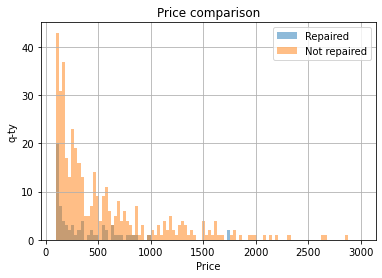

In [29]:
repaired = data[data['Repaired'] == 'yes']
not_repaired = data[data['Repaired'] == 'no']

plt.hist(repaired['Price'].value_counts(), alpha=0.5, bins=100, label = 'Repaired',range=(100,3000))
plt.hist(not_repaired['Price'].value_counts(), alpha=0.5, bins=100, label = 'Not repaired',range=(100,3000))
plt.title('Price comparison')
plt.ylabel('q-ty')
plt.xlabel('Price')
plt.grid(True)
plt.legend();

Check how this information is balanced 

In [30]:
round(data.groupby('Repaired')['Repaired'].count() / (len(data) / 100), 2)

Repaired
no     71.37
yes    10.07
Name: Repaired, dtype: float64

As the car damages are random feature, we can fill this column with random values. Count the total percentage of the data that we have ad add this numbers to the probability form into `random.choice`.

In [31]:
rep = data['Repaired'].isna().values 
u, c = np.unique(data['Repaired'][~rep], return_counts=True)
data.loc[data['Repaired'].isna(), 'Repaired'] = np.random.choice(u, rep.sum(), p=c / c.sum())

In [32]:
round(data.groupby('Repaired')['Repaired'].count() / (len(data) / 100), 2)

Repaired
no     87.59
yes    12.41
Name: Repaired, dtype: float64

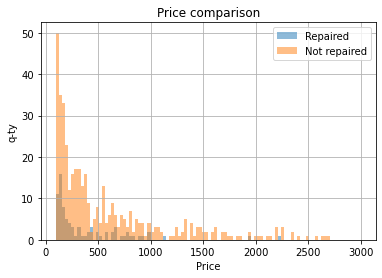

In [33]:
repaired = data[data['Repaired'] == 'yes']
not_repaired = data[data['Repaired'] == 'no']

plt.hist(repaired['Price'].value_counts(), alpha=0.5, bins=100, label = 'Repaired',range=(100,3000))
plt.hist(not_repaired['Price'].value_counts(), alpha=0.5, bins=100, label = 'Not repaired',range=(100,3000))
plt.title('Price comparison')
plt.ylabel('q-ty')
plt.xlabel('Price')
plt.grid(True)
plt.legend();

No critical changes in the histogram after filling in the missing values.

#### Handling the abnormal data

In [34]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
count,334664.000000,334664.000000,334664.000000,334664.000000,334664.000000,334664.000000
mean,4504.346790,2003.923992,111.373195,128562.588148,5.806068,50671.521616
std,4531.438572,69.377219,185.156439,37205.926976,3.689145,25754.522388
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,1067.000000
25%,1150.000000,1999.000000,70.000000,125000.000000,3.000000,30419.000000
50%,2800.000000,2003.000000,105.000000,150000.000000,6.000000,49525.000000
75%,6500.000000,2008.000000,143.000000,150000.000000,9.000000,71229.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,99998.000000


##### Price

Check the histogram

<AxesSubplot:>

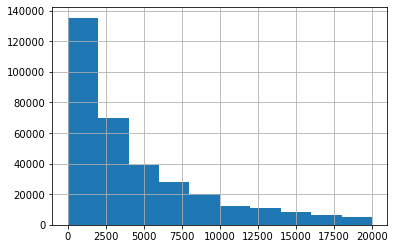

In [35]:
data['Price'].hist()

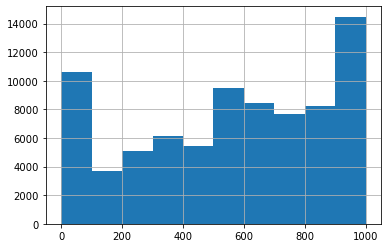

In [36]:
data['Price'].hist(range=(0,1000));

Let's guess that the minimum price could be 100 (in case if the car is being sold for spare parts). Count the percent of price less than 100.

In [37]:
print('There are {} % of cars cheaper than 100'.format(round(data[data['Price'] < 100].value_counts().sum() / (len(data) / 100), 2)))

There are 3.18 % of cars cheaper than 100


We can get rid of this data.

In [38]:
data = data[data['Price'] >= 100]

##### RegistrationYear

Let's look at `boxplot` diagram.

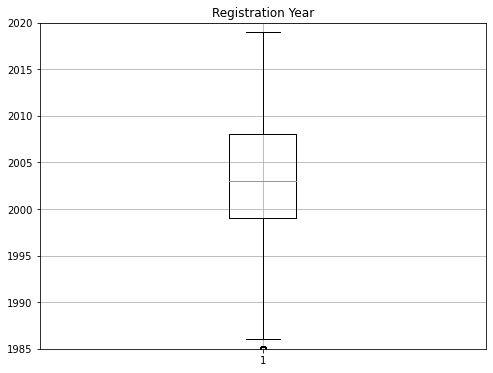

In [39]:
plt.figure(figsize=(8,6))
plt.title('Registration Year')
plt.boxplot(data['RegistrationYear'])
plt.ylim(1985,2020)
plt.grid(True)
plt.show()

Most of the data is between 1986 and 2019.

In [40]:
print('{}% of cars that are older than 1986'.format(round(len(data[data['RegistrationYear'] <= 1986]) / (len(data) / 100), 2)))

1.51% of cars that are older than 1986


We can get rid of this data

In [41]:
data = data[data['RegistrationYear'] >= 1986]

Let's check the maximum date in `DateCrawled`

In [42]:
data['DateCrawled'].max()

Timestamp('2016-04-07 14:36:58')

In [43]:
print('There are {}% of cars above the maximum date'.format(round(len(data[data['RegistrationYear'] > 2016]) / (len(data) / 100), 2)))

There are 3.71% of cars above the maximum date


We can get rid of this data

In [44]:
data = data[data['RegistrationYear'] <= 2017]

##### Power

Let's look at `boxplot` diagram.

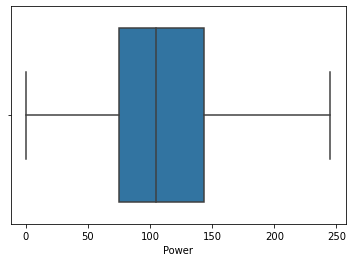

In [45]:
sns.boxplot(x=data['Power'], showfliers=False);

In [46]:
print('There are {} % of cars above the 4th quartile'.format(round(len(data[data['Power'] > 250]) / (len(data) / 100), 2)))

There are 2.06 % of cars above the 4th quartile


We can group the dataset by Model and replace each value that is above the limit with the first value in each group.

In [47]:
data['Power'].replace(range(250,5000), np.nan, inplace=True) 
data.loc[data['Power'].isna(), 'Power'] = \
    data.loc[data['Power'].isna(), 'Model'].map(data.groupby(['Model'])['Power'].first())

In [48]:
data[data['Power'] >= 250].value_counts().sum()

68

Filter all the values above.

In [49]:
data = data[data['Power'] <= 250]

Check the minimum.

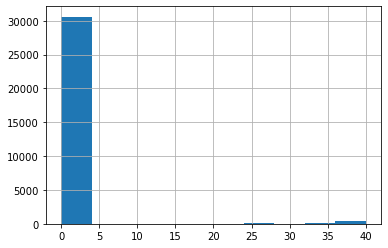

In [50]:
data['Power'].hist(range=(0,40));

In [51]:
round(data[data['Power'] < 40].value_counts().sum() / (len(data) / 100), 2)

9.85

Replace all the values beyond 40 as Nan and replace it with values for unique model. 

In [52]:
data['Power'].replace(range(0,40), np.nan, inplace=True) 
data.loc[data['Power'].isna(), 'Power'] = \
    data.loc[data['Power'].isna(), 'Model'].map(data.groupby(['Model'])['Power'].first())

In [53]:
data['Power'].isna().sum()

0

##### RegistrationMonth

Check the histogram

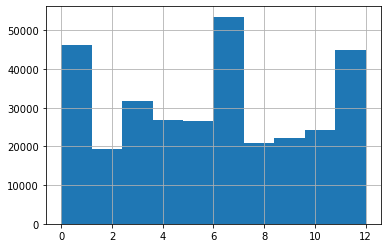

In [54]:
data['RegistrationMonth'].hist();

Replace 0 with NaN and fill in the random month.

In [55]:
data['RegistrationMonth'].replace(0, np.nan, inplace=True) 
data['RegistrationMonth'].fillna(np.random.choice(range(1,13)), inplace=True)

#### Duplicates

In [56]:
data.duplicated().sum()

5

In [57]:
data = data.drop_duplicates().reset_index(drop = True)

Check the % of data that has been deleted.

In [58]:
round(100 - (len(data) / (len(data_row) / 100)), 2)

10.77

Satisfactory

Get rid of columns that are not useful: `DateCrawled`, `DateCreated`, `LastSeen`.

In [59]:
data = data.drop(['DateCrawled', 'DateCreated', 'LastSeen','PostalCode'], axis=1)

In [60]:
data.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired'],
      dtype='object')

#### Check correlations between features

interval columns not set, guessing: ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']


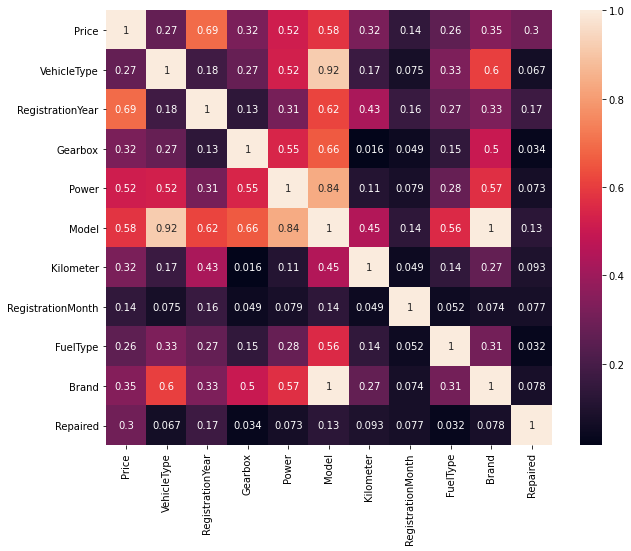

In [61]:
fig = plt.figure(figsize = (10,8))
sns.heatmap(data.phik_matrix(), annot=True);

`Model` is higly correlates with 3 features, it could be better to get rid of this column.

In [62]:
data = data.drop('Model', axis=1)

## Prepairing data for models

Let's split the features and target columns.

In [63]:
features = data.drop('Price', axis=1)
target = data['Price']

### Prepairing samples

Encode categorical features with `Ordinal Encoder`

In [64]:
encoder = OrdinalEncoder()
cat_features = ['VehicleType','Gearbox','RegistrationMonth','FuelType','Repaired','Brand']
features[cat_features] = encoder.fit_transform(features[cat_features])
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
0,5.0,1993,1.0,75.0,150000,7.0,6.0,37.0,0.0
1,6.0,2004,0.0,163.0,125000,7.0,2.0,14.0,0.0
2,5.0,2001,1.0,75.0,150000,5.0,6.0,37.0,0.0
3,5.0,2008,1.0,69.0,90000,6.0,2.0,31.0,0.0
4,4.0,1995,1.0,102.0,150000,9.0,6.0,2.0,1.0


Split the dataset into train and test dataset with proportion 60/40.

In [65]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345)

Check the size of sets:

In [66]:
print('% train:',round((len(features_train) / len(data)*100),2))
print('% test:', round((len(features_test) / len(data)*100),2))

% train: 80.0
% test: 20.0


Standardize some features

In [67]:
numeric = ['Power', 'RegistrationYear','Kilometer']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [68]:
features_train.head(2)

,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
296425,7.0,0.735608,1.0,-0.245319,0.575699,0.0,2.0,37.0,0.0
54006,4.0,0.406554,0.0,0.525139,0.575699,7.0,6.0,37.0,0.0


In [69]:
features_test.head(2)

,VehicleType,RegistrationYear,Gearbox,Power,Kilometer,RegistrationMonth,FuelType,Brand,Repaired
222791,4.0,-1.567772,1.0,-0.575515,0.575699,7.0,6.0,1.0,1.0
192522,6.0,0.900136,1.0,0.437087,0.575699,6.0,2.0,10.0,0.0


Let's make k-Fold cross-validator with 5 splits.

In [70]:
kf = KFold(n_splits=5, shuffle=True)

Make a scorer with a root mean squared error.

In [71]:
rmse = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

Prepare lists for metrics for each model:
1) `value of rmse`;

2) `time of learning`;

3) `best parameters`.

In [72]:
rsme_list = []
time_list = []
best_params_list = []

### Decision Tree Regression.

In [73]:
start = time.time()
#set the parameters 
parametrs = {'max_depth': range (1, 30, 2)}

model_dt = DecisionTreeRegressor(random_state=12345)
grid = GridSearchCV(model_dt, parametrs, scoring = rmse, cv=kf, n_jobs=-1)
grid.fit(features_train, target_train)


stop = time.time()
total_time = (stop - start)/60

rsme_list.append(grid.best_score_)
time_list.append(total_time)
best_params_list.append(grid.best_params_)

print('Best parameters:{}\nBest score:{}\nTotal time:{}'.format(grid.best_params_, grid.best_score_, total_time))


Best parameters:{'max_depth': 13}
Best score:-1952.5195526783343
Total time:0.5662750681241353


### Random forest

In [74]:
start = time.time()

parametrs = {'max_depth': range (1, 10, 2), 'n_estimators': range (1, 100, 20)}
model_rf = RandomForestRegressor(random_state=12345)
grid = GridSearchCV(model_rf, parametrs, scoring = rmse, cv=kf, n_jobs=-1)
grid.fit(features_train, target_train)

stop = time.time()
total_time = (stop - start)/60

rsme_list.append(grid.best_score_)
time_list.append(total_time)
best_params_list.append(grid.best_params_)

print('Best parameters:{}\nBest score:{}\nTotal time:{}'.format(grid.best_params_, grid.best_score_, total_time))

Best parameters:{'max_depth': 9, 'n_estimators': 81}
Best score:-2025.2347124041262
Total time:12.518473370869954


### Linear Regression.

In [75]:
start = time.time()

model_lr = LinearRegression()
rmse_linear = cross_val_score(model_lr, features_train, target_train, scoring = rmse, cv=kf)

stop = time.time()
total_time = (stop - start)/60

rsme_list.append(rmse_linear)
time_list.append(total_time)
best_params_list.append(np.nan)

print('Best score:{}\nTotal time:{}'.format(rmse_linear.min(), total_time))

Best score:-2961.696884439024
Total time:0.009356117248535157


## Model analysis

Make a dataset with all the results

In [76]:
conclusion = [time_list, rsme_list, best_params_list]
index = ['Time', 'RMSE', 'Parameters']
columns = ['DecisionTree','RandomForest', 'LinearRegression'] 
df = pd.DataFrame(conclusion, index, columns) 
df.T.head()


,Time,RMSE,Parameters
DecisionTree,0.566275,-1952.519553,{'max_depth': 13}
RandomForest,12.518473,-2025.234712,"{'max_depth': 9, 'n_estimators': 81}"
LinearRegression,0.009356,"[-2961.696884439024, -2961.687802080476, -2941...",NaN


Decision Tree has the best result with `max_depth`= 13. Let's test it.

In [77]:
start = time.time()

model_dt = DecisionTreeRegressor(max_depth=13, random_state=12345)
model_dt.fit(features_train, target_train)
predict = model_dt.predict(features_test)
rms = mean_squared_error(target_test, predict, squared=False)
stop = time.time()
total_time = (stop - start)/60
print('RMSE: ',rms,'Time: ', total_time)


RMSE:  1904.5992392488224 Time:  0.015990598996480306


Let's check what features our model found to be the most important

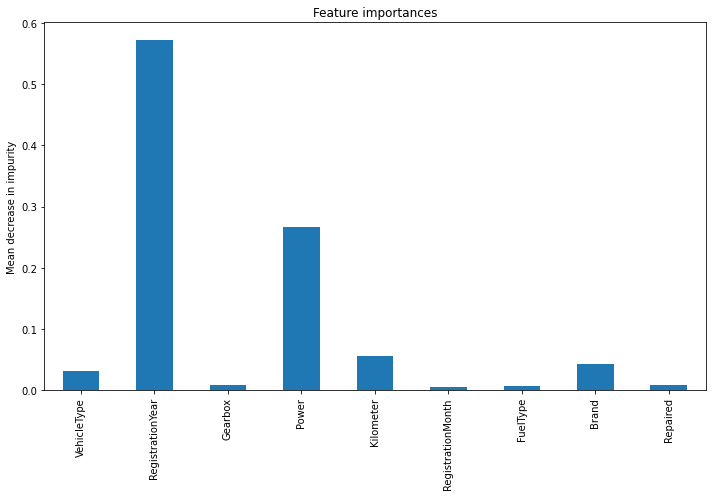

In [78]:
feature_names = features.columns
importances = model_dt.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)

std = np.std([model_dt.feature_importances_ for tree in str(1000)], axis=0)

fig, ax = plt.subplots(figsize=(10,7))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

`registration_year` and `Power` are shown as the most important. Secondary features are `VehicleType`, `Brand` and `Kilometer`.

# Conclusion

The best result is shown by the **Decision Tree**.

**RMSE**:  1904.245068189712 **Time**:  0.012438448270161946

`registration_year` and `Power` are shown as the most important. Secondary features are `VehicleType`, `Brand` and `Kilometer`.